In [1]:
import seaborn as sns
import os
from scipy.stats import kurtosis, skew
import pickle

from rcv_distribution import *
from MDS_analysis import *
from voting_rules import *
import random
from itertools import permutations
from collections import defaultdict
from collections import Counter

c:\Users\mahsh\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\mahsh\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
c:\Users\mahsh\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def load_data(filename, save_folder):
    # Extract the base filename without extension
    base_filename = os.path.splitext(os.path.basename(filename))[0]

    # Create the save paths for dictionary and list
    dict_load_path = os.path.join(save_folder, f"{base_filename}_ballots.pkl")
    list_load_path = os.path.join(save_folder, f"{base_filename}_candidates.pkl")

    # Load the dictionary
    with open(dict_load_path, 'rb') as dict_file:
        data_dict = pickle.load(dict_file)

    # Load the list
    with open(list_load_path, 'rb') as list_file:
        data_list = pickle.load(list_file)

    return data_dict, data_list



In [3]:
filename = "SanLeandro_11062012_CountyCouncilDistrict2"
ballots, candidates = load_data(filename, "saved_ballots_and_candidates")
print(candidates)

['URSULA REED', 'MORGAN MACK-ROSE', 'DAN DILLMAN']


In [4]:
real_election = voting_rules(ballots, candidates)
print(real_election.irv())

DAN DILLMAN
12086   11998.5
12086   11998.5
('URSULA REED', {'round_1': {'URSULA REED': 10763, 'DAN DILLMAN': 4853, 'MORGAN MACK-ROSE': 9719}, 'majority': {'URSULA REED': 12086, 'MORGAN MACK-ROSE': 11911}})


In [ ]:
directory = "dataverse_files"
table = pd.read_csv("permissive.csv")
for filename in os.listdir(directory):
    try:
        csv = os.path.join(directory, filename)
        ballots, candidates = parse_election_data(csv)

        null_directory = "null_elections"
        
        df = pd.read_csv(os.path.join(null_directory, filename))
        normalized_distances = pd.Series(df['position'].values, index=df['candidate']).to_dict()

        consistent_ballots, gamma = get_permissive_gamma(ballots, normalized_distances)

        election = voting_rules(ballots, candidates)
        consistent_election = voting_rules(consistent_ballots, candidates)

        irv1 = election.irv()
        irv2 = consistent_election.irv()

        if (irv1 != irv2):
            table.loc[table["filename"] == filename, "linear voters failure"] = "yes"
            print(filename, ": actual election: ", irv1, " consistent election: ", irv2)
        else:
            table.loc[table["filename"] == filename, "linear voters failure"] = "no"
            print("same winner: ", filename, ": actual election: ", irv1, " consistent election: ", irv2)
    except Exception as e:
        # Print the summary of the error
        print(f"An error occurred: {e}")
        
table.to_csv("diff.csv")

In [ ]:
table[table["linear voters failure"]=='yes']

In [2]:
def generate_permutations(items, k):
    all_permutations = []
    
    for length in range(1, k + 1):
        perms = permutations(items, length)
        all_permutations.extend(perms)
    
    return all_permutations

In [4]:
def generate_and_group_permutations(items, choices):
    n = len(items)
    grouped_permutations = defaultdict(list)
    
    for i in range(1, choices + 1):
        for perm in permutations(items, i):
            grouped_permutations[perm[0]].append(perm)
    
    return grouped_permutations

In [5]:
# This function is keeping the first place choices of the inconsistent voters.
def generate_inconsistent_ballots(ballots, candidates, filename, runs):
    directory = "null_elections"
    csv = os.path.join(directory, filename) 
    df = pd.read_csv(csv)  
    candidates = df['candidate'].values
    election = pd.read_csv("election_table.csv")
    choices = min(len(candidates), round(election.loc[election['filename']==filename, 'choices'].values[0]))
    if choices == 1:
        choices = len(candidates)
    print(choices)
    normalized_distances = pd.Series(df['position'].values, index=df['candidate']).to_dict()
    print(normalized_distances)
    #plot_KDE(ballots, normalized_distances)
    consistent_ballots, gamma = get_permissive_gamma(ballots, normalized_distances)

    all_voters = 0
    for b in ballots:
        if len(b) > 0:
            all_voters += ballots[b]
    consistent_voters = sum(consistent_ballots.values())
    inconsistent_voters = all_voters - consistent_voters
    #print(inconsistent_voters)

    
    grouped_permutations = generate_and_group_permutations(candidates, choices)
    
    for candidate, perms in grouped_permutations.items():
        grouped_permutations[candidate] = [perm for perm in perms if (perm not in consistent_ballots) and is_consistent(perm, normalized_distances)==False]
        """print(grouped_permutations[c])
        for ranking in grouped_permutations[c]:
            if ranking in consistent_ballots:
                print(ranking)
                grouped_permutations[c].remove(ranking)
            else:
                print(ranking, " was not in consistent ballots")"""
    #print(grouped_permutations)

    inconsistent_ballots = {}
    for b in ballots:
        if len(b) > 0 and b not in consistent_ballots:
            if b not in inconsistent_ballots:
                inconsistent_ballots[b] = 0
            inconsistent_ballots[b] += ballots[b]


    candidates_freq = {}
    for b in inconsistent_ballots:
        candidate = b[0]
        if candidate not in candidates_freq:
            candidates_freq[candidate] = 0
        candidates_freq[candidate] += inconsistent_ballots[b]
    #print(candidates_freq)

    random_inconsistent_ballots = {} 

    for i in range(runs):
        for candidate in candidates_freq:
            first_place = candidates_freq[candidate]
            if first_place > 0:
               
                random_ballots = random.choices(grouped_permutations[candidate], k=first_place)
                for b in random_ballots:
                    if b not in random_inconsistent_ballots:
                        random_inconsistent_ballots[b] = 0
                    random_inconsistent_ballots[b] += 1
    return random_inconsistent_ballots, consistent_ballots



In [1]:
# This function is generating totaly random ballots instead of the inconsistent ones (not keeping the first place choices)

def generate_random_inconsistent_ballots(ballots, candidates, filename):
    filename = filename + ".csv"
    election = pd.read_csv("election_table.csv")
    choices = min(len(candidates), round(election.loc[election['filename']==filename, 'choices'].values[0]))
    if choices == 1:
        choices = len(candidates)

    #print(choices)
    directory = "null_elections"
    csv = os.path.join(directory, filename) 
    df = pd.read_csv(csv)

    perms = generate_permutations(candidates, choices)

    normalized_distances = pd.Series(df['position'].values, index=df['candidate']).to_dict()
    #print(normalized_distances)
    consistent_ballots, gamma = get_permissive_gamma(ballots, normalized_distances)

    perms = [perm for perm in perms if (perm not in consistent_ballots) and is_consistent(perm, normalized_distances)==False]    
    
   
    all_voters = 0
    for b in ballots:
        if len(b) > 0:
            all_voters += ballots[b]
    consistent_voters = sum(consistent_ballots.values())
    inconsistent_voters = all_voters - consistent_voters
    inconsistent_ballots_list = random.choices(perms, k=inconsistent_voters)
    inconsistent_ballots = {}

    for ballot in inconsistent_ballots_list:
        if ballot not in inconsistent_ballots:
            inconsistent_ballots[ballot] = 0
        inconsistent_ballots[ballot] += 1

    return inconsistent_ballots, consistent_ballots
    

['William Rivera', 'Darlene Jackson', 'Amanda Farias', 'William Russell Moore', 'Michael Beltzer', 'Eliu A. Lara', 'Mohammed Mujumder', 'Mirza M. Rashid']


In [18]:
freqs = get_frequency(ballots, candidates)
print(freqs)

{'Bob Kiss': 0.28885172798216274, 'Andy Montroll': 0.23166109253065775, 'Kurt Wright': 0.329654403567447, 'Dan Smith': 0.14593088071348942, 'James Simpson': 0.0039018952062430325}


In [19]:
inconsistent_ballots, consistent_ballots = generate_random_inconsistent_ballots(ballots, candidates, filename)
combined_ballots = {**consistent_ballots, **inconsistent_ballots}

5
{'Bob Kiss': 4.0, 'Andy Montroll': 3.002996715437522, 'Kurt Wright': 1.4063798104123542, 'Dan Smith': 2.2741862621591853, 'James Simpson': 0.0}


In [156]:
inconsistent_ballots, consistent_ballots = generate_random_inconsistent_ballots(ballots, candidates, filename)
combined_ballots = {**consistent_ballots, **inconsistent_ballots}


real_election = voting_rules(ballots, candidates)
consistent_election = voting_rules(consistent_ballots, candidates)
random_election = voting_rules(combined_ballots, candidates)
#print("condorcet winner: ", real_election.condorcet())

print("real winner: ", real_election.irv()[0])
print(real_election.irv()[1])
print("only consistent: ", consistent_election.irv()[0])
print(consistent_election.irv()[1])
print("random election: ", random_election.irv()[0])

real winner:  Amanda Farias
{'round_1': {'William Rivera': 3788, 'Amanda Farias': 3884, 'Darlene Jackson': 1592, 'Michael Beltzer': 1876, 'William Russell Moore': 591, 'Mohammed Mujumder': 1429, 'Eliu A. Lara': 143, 'Mirza M. Rashid': 728}, 'round_2': {'William Rivera': 3823, 'Amanda Farias': 3910, 'Darlene Jackson': 1603, 'Michael Beltzer': 1895, 'William Russell Moore': 596, 'Mohammed Mujumder': 1439, 'Mirza M. Rashid': 730}, 'round_3': {'William Rivera': 3901, 'Amanda Farias': 3969, 'Darlene Jackson': 1788, 'Michael Beltzer': 1962, 'Mohammed Mujumder': 1469, 'Mirza M. Rashid': 742}, 'round_4': {'William Rivera': 3945, 'Amanda Farias': 4073, 'Darlene Jackson': 1828, 'Michael Beltzer': 1987, 'Mohammed Mujumder': 1781}, 'round_5': {'William Rivera': 4286, 'Amanda Farias': 4563, 'Darlene Jackson': 1984, 'Michael Beltzer': 2099}, 'round_6': {'William Rivera': 4664, 'Amanda Farias': 5151, 'Michael Beltzer': 2429}, 'round_7': {'William Rivera': 5491, 'Amanda Farias': 6037}}
only consistent

In [13]:
filename = "Maine_06122018_DemocraticPrimaryforCD2"
ballots, candidates = load_data(filename, "saved_ballots_and_candidates")
print(candidates)

['Olson, Craig R.', 'Golden, Jared F.', 'St. Clair, Lucas R.', 'Fulford, Jonathan S.']


In [11]:
real_election = voting_rules(ballots, candidates)
print(real_election.irv())

('JoAnne Vigil Coppler', {'round_1': {'JoAnne Vigil Coppler': 2121, 'Eric John Holmes': 1308, 'Greg Scargall': 1474}, 'majority': {'JoAnne Vigil Coppler': 2565, 'Greg Scargall': 1979}})


In [14]:
real = 0
consistent = 0
real_election = voting_rules(ballots, candidates)
for i in range(100):
    
    
    inconsistent_ballots, consistent_ballots = generate_random_inconsistent_ballots(ballots, candidates, filename)
    combined_ballots = {**consistent_ballots, **inconsistent_ballots}

    
    consistent_election = voting_rules(consistent_ballots, candidates)
    random_election = voting_rules(combined_ballots, candidates)
    #print("condorcet winner: ", real_election.condorcet())

    #print("real winner: ", real_election.irv()[0])
    #print(real_election.irv()[1])
    #print("only consistent: ", consistent_election.irv()[0])
    #print(consistent_election.irv()[1])
    #print("random election: ", random_election.irv()[0])
    #print(random_election.irv()[1])
    if (real_election.irv()[0] == random_election.irv()[0]):
        real += 1
    if (consistent_election.irv()[0] == random_election.irv()[0]):
        consistent += 1

print(real_election.irv()[1], real_election.irv()[0])
print(consistent_election.irv()[1], consistent_election.irv()[0])
for b in ballots:
    print(b, " ", ballots[b])
print("random == real: ", real)
print("random == consistent: ", consistent)


{'round_1': {'Olson, Craig R.': 4017, 'Golden, Jared F.': 21038, 'St. Clair, Lucas R.': 17796, 'Fulford, Jonathan S.': 2506}, 'round_2': {'Olson, Craig R.': 4555, 'Golden, Jared F.': 21895, 'St. Clair, Lucas R.': 18275}, 'majority': {'Golden, Jared F.': 23673, 'St. Clair, Lucas R.': 19934}} Golden, Jared F.
{'round_1': {'Golden, Jared F.': 15209, 'Olson, Craig R.': 2814, 'St. Clair, Lucas R.': 15172, 'Fulford, Jonathan S.': 1235}, 'round_2': {'Golden, Jared F.': 15304, 'Olson, Craig R.': 3139, 'St. Clair, Lucas R.': 15355}, 'majority': {'Golden, Jared F.': 15666, 'St. Clair, Lucas R.': 17014}} St. Clair, Lucas R.
('Olson, Craig R.', 'Golden, Jared F.', 'St. Clair, Lucas R.')   370
('Golden, Jared F.',)   5719
('Olson, Craig R.',)   965
()   5488
('St. Clair, Lucas R.',)   4733
('Golden, Jared F.', 'Olson, Craig R.', 'St. Clair, Lucas R.', 'Fulford, Jonathan S.')   984
('Golden, Jared F.', 'St. Clair, Lucas R.', 'Olson, Craig R.')   2048
('St. Clair, Lucas R.', 'Golden, Jared F.', 'Fulf

In [30]:
ignore = [] 
for c in freqs:
    if freqs[c] < 0.02:
        ignore.append(c)
print(ignore)

[]


In [5]:
ballots, candidates = parse_election_data(os.path.join("dataverse_files", filename), ignore_values=ignore)

In [20]:
print(candidates)
inconsistent_ballots, consistent_ballots = generate_random_inconsistent_ballots(ballots, candidates, filename)

['Cathy Spann', 'Jeremiah Ellison', 'Kristel Porter', 'Elijah Norris-Holliday', 'Victor Martinez', 'Suleiman Isse', 'James "Jim" Seymour']


NameError: name 'generate_random_inconsistent_ballots' is not defined

In [3]:
# Perform the RCV analysis
test = perform_rcv_analysis(ballots, candidates, n_init = 100, max_itr = 1000, n_runs=1000, metric=False)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = test

# Print the normalized distances between candidates and plot the MDS analysis
normalized_distances_original = get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names)
print("Normalized distances:", normalized_distances_original)

c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\cleaned files\MDS_analysis.py:162: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Normalized distances: {'REP Poliquin, Bruce': 0.0, 'Hoar, William R.S.': 1.2308639702038415, 'Bond, Tiffany L.': 1.9934720926442377, 'DEM Golden, Jared F.': 3.0}


In [32]:
consistent_ballots, gamma = get_permissive_gamma(ballots, normalized_distances_original)
print(gamma)

0.8437871576328024


In [4]:
plot_KDE(ballots, normalized_distances_original, filename, save=True)

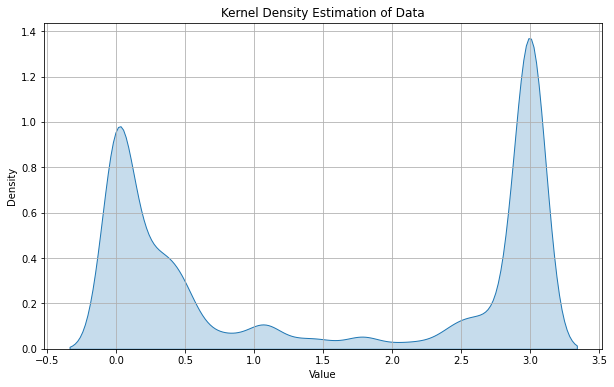

In [6]:
loaded_array = np.load('np_data/Maine_11062018_CongressionalDistrict2.npy')
plt.figure(figsize=(10, 6))
sns.kdeplot(loaded_array, fill=True)
plt.title('Kernel Density Estimation of Data')
#plt.xticks(normalized_points, normalized_names, rotation=45)
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)

In [28]:
inconsistent_ballots, consistent_ballots = generate_random_inconsistent_ballots(ballots, candidates, filename)
random_ballots = {**consistent_ballots, **inconsistent_ballots}

random_elction = voting_rules(random_ballots, candidates)
winner_random = random_elction.irv()
print("random: ", winner_random[0])
print("symmary:")
for r in winner_random[1]:
    print(r, "  ", winner_random[1][r])

election = voting_rules(ballots, candidates)
winner_real = election.irv()
print("real: ", winner_real[0])
print("symmary:")
for r in winner_real[1]:
    print(r, "  ", winner_real[1][r])

consistent_election = voting_rules(consistent_ballots, candidates)
winner_consistent = consistent_election.irv()
print("consistent: ", winner_consistent[0])

for r in winner_consistent[1]:
    print(r, "  ", winner_consistent[1][r])


10
{'Buxton, Catherine A.': 2.042671871132112, 'Chann, Marpheen S.': 3.291470658191624, 'Sheikh-Yousef, Nasreen A.': 1.8103836498763624, 'Emerson, Anthony M.': 0.5273134036930769, 'Washburn, Patricia J.': 1.502520882213786, 'DiMillo, Steven A.': 5.689746802700792, 'Condrey, Lawson T.': 0.0, 'Grant, Benjamin K.': 3.671776758253359, 'Bailey, William M.': 6.131637367680072, 'Houseal, Ian P.': 4.5668315421325705, 'Rovelto, Hope R.': 10.0}


KeyboardInterrupt: 

In [5]:

random_inconsistent_ballots, consistent_ballots = generate_inconsistent_ballots(ballots, candidates, filename, runs=1)
print(random_inconsistent_ballots)

{('SHENG THAO', 'TYRON C. JORDAN', 'IGNACIO DE LA FUENTE', 'SENECA SCOTT', 'LOREN MANUEL TAYLOR'): 12, ('SHENG THAO', 'TYRON C. JORDAN', 'GREGORY HODGE', 'SENECA SCOTT'): 7, ('SHENG THAO', 'TREVA D. REID', 'LOREN MANUEL TAYLOR', 'IGNACIO DE LA FUENTE', 'GREGORY HODGE'): 11, ('SHENG THAO', 'TYRON C. JORDAN', 'JOHN REIMANN', 'TREVA D. REID', 'SENECA SCOTT'): 7, ('SHENG THAO', 'PETER Y. LIU', 'JOHN REIMANN', 'ALLYSSA VICTORY VILLANUEVA', 'TYRON C. JORDAN'): 13, ('SHENG THAO', 'GREGORY HODGE', 'SENECA SCOTT', 'LOREN MANUEL TAYLOR', 'TYRON C. JORDAN'): 14, ('SHENG THAO', 'SENECA SCOTT', 'TYRON C. JORDAN', 'TREVA D. REID', 'ALLYSSA VICTORY VILLANUEVA'): 6, ('SHENG THAO', 'LOREN MANUEL TAYLOR', 'SENECA SCOTT', 'TYRON C. JORDAN', 'TREVA D. REID'): 7, ('SHENG THAO', 'LOREN MANUEL TAYLOR', 'IGNACIO DE LA FUENTE', 'ALLYSSA VICTORY VILLANUEVA', 'JOHN REIMANN'): 8, ('SHENG THAO', 'IGNACIO DE LA FUENTE', 'SENECA SCOTT', 'LOREN MANUEL TAYLOR', 'GREGORY HODGE'): 8, ('SHENG THAO', 'TREVA D. REID', 'IGN

In [36]:
runs = 1
count = 0
for i in range(runs):
    random_inconsistent_ballots, consistent_ballots = generate_random_inconsistent_ballots(ballots, candidates, filename)

    random_ballots = {**consistent_ballots, **random_inconsistent_ballots}

    print("generated ballots")
    for b in random_ballots:
        if b in consistent_ballots:
            c = "consistent"
        else:
            c = "inconsistent"
        print(b, " ", random_ballots[b], c)
    
    random_elction = voting_rules(random_ballots, candidates)
    print("random: ", random_elction.irv())

    print("real ballots")
    for b in ballots:
        print(b, " " , ballots[b])
    election = voting_rules(ballots, candidates)
    print("real: ", election.irv())

    consistent_election = voting_rules(consistent_ballots, candidates)
    print("consistent: ", consistent_election.irv())

    print("consistent ballots")
    for b in consistent_ballots:
        print(b, " ", consistent_ballots[b])
    for b in random_ballots:
        if b not in consistent_ballots:
            print(b, " ", random_ballots[b])
    

    if random_elction.irv() == election.irv():
        count += 1
    print()
print(count)

3
{'Cam Gordon': 3.001461293568189, 'Robin Wonsley Worlobah': 4.0, 'Yusra Arab': 2.6285290356824835, 'Tom Anderson': 2.3619814063116333, 'Guy T Gaskin': 0.0}
generated ballots
('Cam Gordon', 'Robin Wonsley Worlobah', 'Yusra Arab')   334 consistent
('Yusra Arab', 'Tom Anderson')   358 consistent
('Yusra Arab', 'Tom Anderson', 'Cam Gordon')   257 consistent
('Yusra Arab',)   802 consistent
('Cam Gordon', 'Robin Wonsley Worlobah')   596 consistent
('Yusra Arab', 'Tom Anderson', 'Robin Wonsley Worlobah')   196 consistent
('Robin Wonsley Worlobah', 'Cam Gordon')   643 consistent
('Cam Gordon', 'Yusra Arab')   211 consistent
('Cam Gordon', 'Robin Wonsley Worlobah', 'Tom Anderson')   130 consistent
('Guy T Gaskin',)   302 consistent
('Robin Wonsley Worlobah', 'Yusra Arab')   261 consistent
('Robin Wonsley Worlobah',)   405 consistent
('Cam Gordon',)   484 consistent
('Tom Anderson', 'Yusra Arab')   211 consistent
('Yusra Arab', 'Cam Gordon')   263 consistent
('Yusra Arab', 'Cam Gordon', 'Tom 

In [123]:
print(sum(random_inconsistent_ballots.values()))
for b in random_inconsistent_ballots:
    if len(b) > 0:
        print(b, ": ", random_inconsistent_ballots[b])

41124
('Bernardo Tuma', 'Dale Washam', 'Jan Shabro') :  614
('Bernardo Tuma', 'Dale Washam', 'Terry Lee') :  669
('Bernardo Tuma', 'Jan Shabro', 'Barbara Gelman') :  657
('Bernardo Tuma', 'Terry Lee', 'Beverly Davidson') :  670
('Bernardo Tuma', 'Dale Washam', 'Beverly Davidson') :  628
('Bernardo Tuma', 'Jan Shabro', 'Beverly Davidson') :  646
('Bernardo Tuma', 'Barbara Gelman', 'Beverly Davidson') :  621
('Bernardo Tuma', 'Terry Lee', 'Barbara Gelman') :  616
('Bernardo Tuma', 'Terry Lee', 'Jan Shabro') :  666
('Bernardo Tuma', 'Dale Washam', 'Barbara Gelman') :  622
('Beverly Davidson', 'Terry Lee', 'Jan Shabro') :  782
('Beverly Davidson', 'Dale Washam', 'Jan Shabro') :  799
('Beverly Davidson', 'Terry Lee', 'Barbara Gelman') :  814
('Beverly Davidson', 'Dale Washam', 'Barbara Gelman') :  859
('Beverly Davidson', 'Jan Shabro', 'Barbara Gelman') :  824
('Beverly Davidson', 'Dale Washam', 'Terry Lee') :  844
('Jan Shabro', 'Bernardo Tuma', 'Beverly Davidson') :  1234
('Jan Shabro', '

In [128]:
random_ballots = {**consistent_ballots, **random_inconsistent_ballots}
random_elction = voting_rules(random_ballots, candidates)
print("random: ", random_elction.irv())

election = voting_rules(ballots, candidates)
print("real: ", election.irv())

consistent_election = voting_rules(consistent_ballots, candidates)
print("consistent: ", consistent_election.irv())

random:  Dale Washam
real:  Dale Washam
consistent:  Dale Washam


In [55]:
for b in consistent_ballots:
    print(b)

('Peltola, Mary S.', 'Begich, Nick')
('Peltola, Mary S.',)
('Peltola, Mary S.', 'Begich, Nick', 'Palin, Sarah')
('Palin, Sarah',)
('Begich, Nick', 'Palin, Sarah', 'Peltola, Mary S.')
('Begich, Nick',)
('Begich, Nick', 'Peltola, Mary S.', 'Palin, Sarah')
('Palin, Sarah', 'Begich, Nick')
('Palin, Sarah', 'Begich, Nick', 'Peltola, Mary S.')
('Begich, Nick', 'Peltola, Mary S.')
('Begich, Nick', 'Palin, Sarah')
('Peltola, Mary S.', 'Palin, Sarah')
('Palin, Sarah', 'Peltola, Mary S.')


In [99]:
for b in ballots:
    print(b, ": ", ballots[b])

('Hinda Miller', 'Kevin Curley', 'Louie the Cowman Beaudin') :  10
('Bob Kiss', 'Hinda Miller', 'Loyal Ploof') :  86
('Hinda Miller', 'Bob Kiss') :  886
('Bob Kiss', 'Hinda Miller') :  1142
('Bob Kiss', 'Hinda Miller', 'Louie the Cowman Beaudin') :  77
('Loyal Ploof', 'Louie the Cowman Beaudin', 'Kevin Curley', 'Hinda Miller', 'Bob Kiss') :  1
('Bob Kiss', 'Hinda Miller', 'Kevin Curley') :  254
('Hinda Miller', 'Bob Kiss', 'Louie the Cowman Beaudin', 'Kevin Curley', 'Loyal Ploof') :  22
('Hinda Miller',) :  551
('Bob Kiss', 'Kevin Curley', 'Hinda Miller', 'Loyal Ploof', 'Louie the Cowman Beaudin') :  75
('Hinda Miller', 'Bob Kiss', 'Kevin Curley') :  202
('Bob Kiss',) :  495
('Hinda Miller', 'Bob Kiss', 'Kevin Curley', 'Loyal Ploof', 'Louie the Cowman Beaudin') :  96
('Kevin Curley',) :  802
('Bob Kiss', 'Loyal Ploof', 'Hinda Miller') :  25
('Kevin Curley', 'Louie the Cowman Beaudin', 'Loyal Ploof') :  35
('Hinda Miller', 'Bob Kiss', 'Kevin Curley', 'Louie the Cowman Beaudin') :  31
('

In [107]:
random_ballots = {**consistent_ballots, **random_inconsistent_ballots}

In [108]:
for b in random_ballots:
    if len(b) > 0:
        print(b, ": ", random_ballots[b])

('Andrew Struthers', 'Roen Hogg', 'Charles Maughan') :  2119
('Andrew Struthers', 'Charles Maughan', 'Roen Hogg') :  3722
('Andrew Struthers', 'Charles Maughan') :  511
('Andrew Struthers', 'Roen Hogg') :  279
('Andrew Struthers',) :  521
('Charles Maughan', 'Andrew Struthers', 'Roen Hogg') :  4405
('Charles Maughan', 'Andrew Struthers') :  760
('Charles Maughan', 'Roen Hogg') :  197
('Charles Maughan',) :  372
('Roen Hogg',) :  847
('Roen Hogg', 'Andrew Struthers', 'Charles Maughan') :  2484
('Roen Hogg', 'Andrew Struthers') :  228
('Roen Hogg', 'Charles Maughan') :  168
('Charles Maughan', 'Roen Hogg', 'Andrew Struthers') :  2183
('Roen Hogg', 'Charles Maughan', 'Andrew Struthers') :  1809


In [111]:
election = voting_rules(ballots, candidates)
print(election.irv())

Charles Maughan


In [112]:
consistent_election = voting_rules(consistent_ballots, candidates)
print (consistent_election.irv())

Andrew Struthers


In [114]:
random_elction = voting_rules(random_ballots, candidates)
print(random_elction.irv())

Charles Maughan


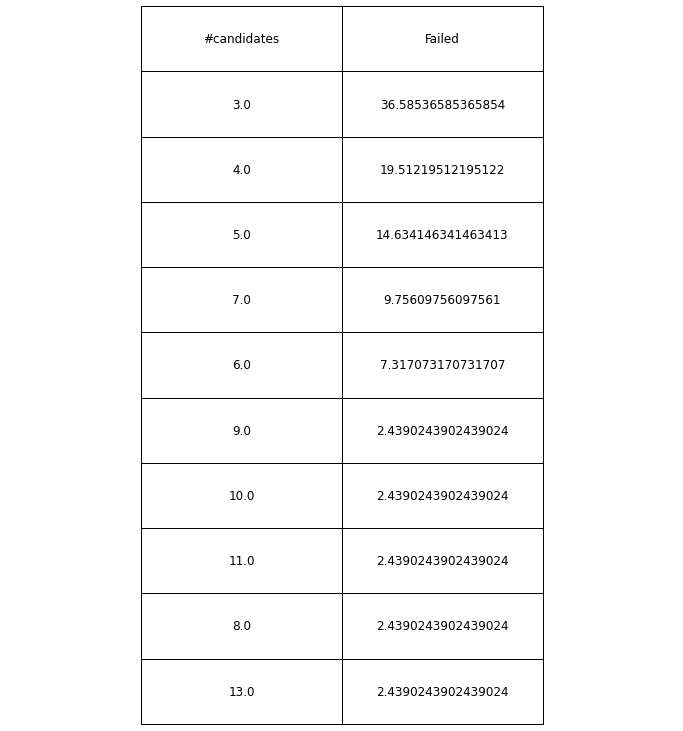

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('median_voter_analysis.csv')

# Define a function to calculate and plot percentages
def plot_percentage_table(df, column, output_file):
    # Calculate the percentage of 'yes' in each category
    percentage_yes = df[df['linear voters failure'] == 'yes'][column].value_counts(normalize=True) * 100
    percentage_yes = percentage_yes.reset_index()
    percentage_yes.columns = [column, 'Failed']
    
    # Plot the table
    plt.figure(figsize=(12, 12))
    table = plt.table(cellText=percentage_yes.values, colLabels=percentage_yes.columns, cellLoc='center', loc='center')
    # Set font size and scale for better readability
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    
    # Adjust the cell widths and heights
    cell_width = 0.3
    cell_height = 0.1
    for key, cell in table.get_celld().items():
        cell.set_width(cell_width)
        cell.set_height(cell_height)
    
    plt.axis('off')
    #plt.title(f'Percentage of failure of the linear voters', fontsize=14)
    #plt.savefig(output_file, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

# Plot and save the tables for 'level', '#candidates', 'partisan', and 'type'
#plot_percentage_table(df, 'level', 'level_percentage_table.png')
plot_percentage_table(df, '#candidates', 'candidates_percentage_table.png')
#plot_percentage_table(df, 'partisan', 'partisan_percentage_table.png')
#plot_percentage_table(df, 'type', 'type_percentage_table.png')


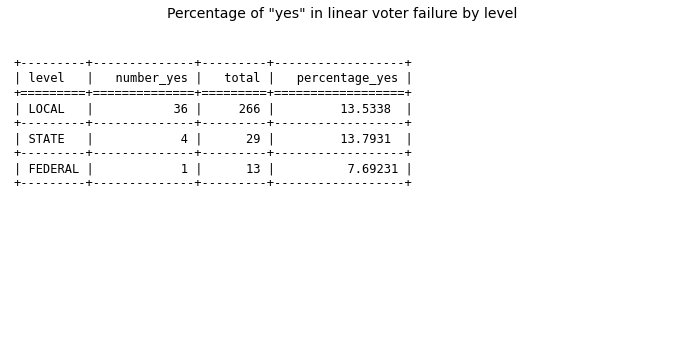

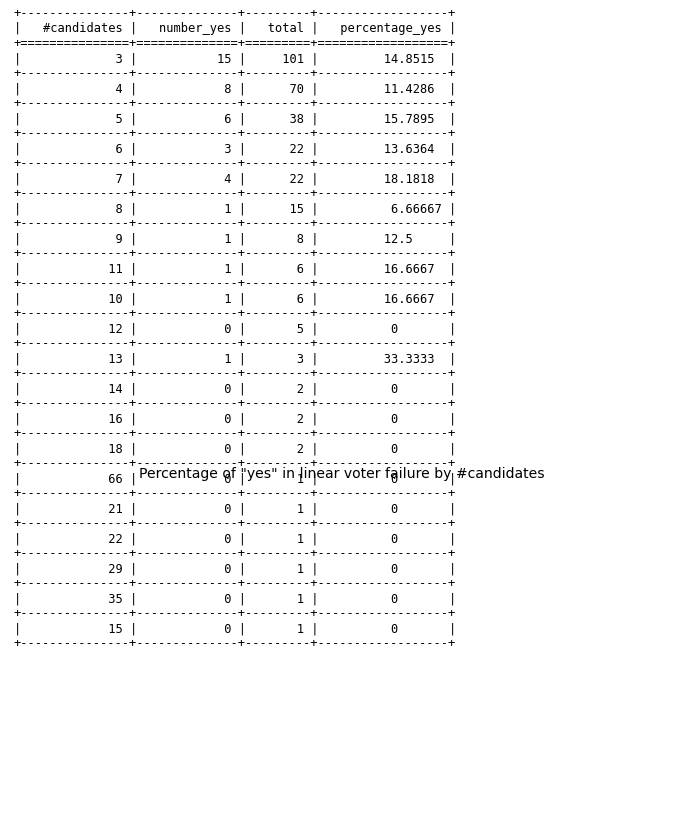

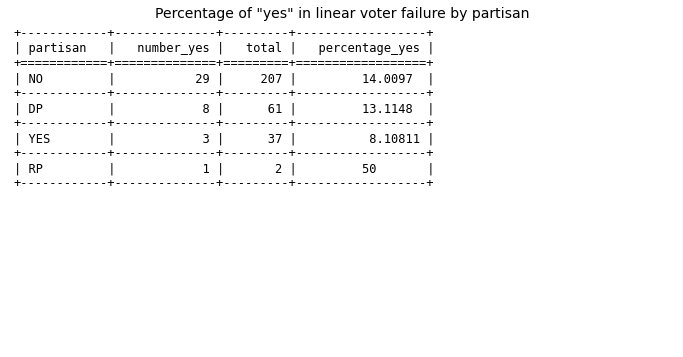

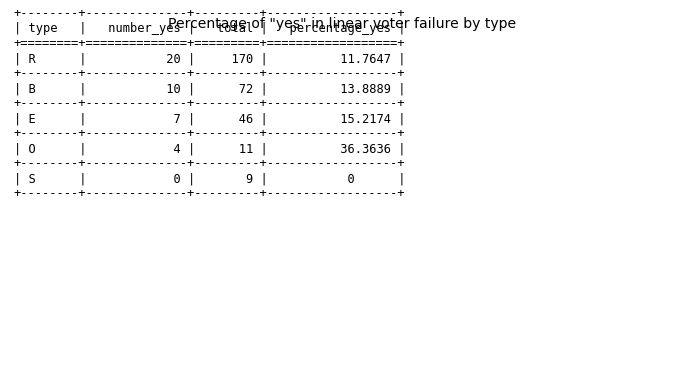

In [28]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import io

# Load the CSV file
df = pd.read_csv('median_voter_analysis.csv')
df = df[df['#candidates'] > 2]

# Define a function to calculate and plot percentages with totals and number of 'yes'
def plot_percentage_table(df, column, output_file):
    # Calculate the counts and percentages
    counts = df[df['linear voters failure'] == 'yes'][column].value_counts()
    total_counts = df[column].value_counts()
    
    # Align indices and fill missing values with 0
    counts = counts.reindex(total_counts.index, fill_value=0)
    percentage_yes = (counts / total_counts) * 100

    # Create the DataFrame
    data = pd.DataFrame({
        column: counts.index,
        'number_yes': counts.values,
        'total': total_counts.values,
        'percentage_yes': percentage_yes.values
    }).fillna(0)  # Fill NaN with 0 for categories with no 'yes'

    # Create a table using tabulate
    table_str = tabulate(data, headers='keys', tablefmt='grid', showindex=False)

    # Save the table as an image
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('off')
    plt.text(0.01, 0.5, table_str, {'family': 'monospace'}, fontsize=12)
    plt.title(f'Percentage of "yes" in linear voter failure by {column}', fontsize=14)
    #plt.savefig(output_file, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

# Plot and save the tables for 'level', '#candidates', 'partisan', and 'type'
plot_percentage_table(df, 'level', 'level_percentage_table.png')
plot_percentage_table(df, '#candidates', 'candidates_percentage_table.png')
plot_percentage_table(df, 'partisan', 'partisan_percentage_table.png')
plot_percentage_table(df, 'type', 'type_percentage_table.png')
